# Simple Backtest for SPY Trading Strategy

This notebook backtests a trading strategy based on model predictions, comparing it to a buy-and-hold benchmark.

## Strategy Logic:
- **Prediction = 1 (Up)**: Hold the stock, earn that day's return
- **Prediction = 0 (Down)**: Stay in cash, earn 0% return
- **Commission**: 0.1% deducted when position changes (0→1 or 1→0)

## Performance Metrics:
- **Sharpe Ratio**: Risk-adjusted return measure = (Mean Return / Std Dev) * √252
- **Maximum Drawdown**: Largest peak-to-trough decline in equity curve
- **Equity Curve**: Cumulative account value over time


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from typing import Tuple, Any

# Try to import xgboost (may fail on macOS without libomp)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost not available - will only load sklearn models (.pkl)")

# Set style for better plots (use compatible style)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")


⚠ XGBoost not available - will only load sklearn models (.pkl)


In [2]:
def load_data_and_model(
    data_path: str = "data/processed/spy_featured.csv",
    model_path: str = "models/xgboost_spy_v1.json"
) -> Tuple[pd.DataFrame, Any, str]:
    """
    Load processed data and trained model.
    
    Args:
        data_path: Path to processed CSV file
        model_path: Path to saved model file
    
    Returns:
        Tuple of (DataFrame, model, model_type)
    """
    # Try multiple possible locations for data
    # Get current working directory and try to find project root
    cwd = Path.cwd()
    project_root = None
    
    # Try to find project root
    for check_path in [cwd, cwd.parent, cwd.parent.parent]:
        if (check_path / "data").exists() or (check_path / "requirements.txt").exists():
            project_root = check_path
            break
    
    if project_root is None:
        project_root = cwd
    
    possible_data_paths = [
        Path(data_path),
        Path("../data/processed/spy_featured.csv"),
        Path("../../data/processed/spy_featured.csv"),
        project_root / "data" / "processed" / "spy_featured.csv",
    ]
    
    df = None
    for path in possible_data_paths:
        if path.exists():
            df = pd.read_csv(path)
            # Parse datetime with utc=True to handle mixed timezones
            df['time'] = pd.to_datetime(df['time'], utc=True)
            df = df.sort_values('time').reset_index(drop=True)
            print(f"✓ Loaded data from: {path}")
            print(f"  Shape: {df.shape}")
            break
    
    if df is None:
        raise FileNotFoundError(f"Could not find data file. Tried: {possible_data_paths}")
    
    # Try multiple possible locations for model
    # Build comprehensive list of possible model paths
    base_paths = [
        Path(model_path),
        Path(model_path.replace('.json', '.pkl')),
        Path("../models/xgboost_spy_v1.json"),
        Path("../models/xgboost_spy_v1.pkl"),
        Path("../../models/xgboost_spy_v1.json"),
        Path("../../models/xgboost_spy_v1.pkl"),
        project_root / "models" / "xgboost_spy_v1.json",
        project_root / "models" / "xgboost_spy_v1.pkl",
        Path("models/xgboost_spy_v1.json"),
        Path("models/xgboost_spy_v1.pkl"),
    ]
    
    # Remove duplicates while preserving order
    seen = set()
    possible_model_paths = []
    for path in base_paths:
        path_resolved = path.resolve()
        if path_resolved not in seen:
            seen.add(path_resolved)
            possible_model_paths.append(path)
    
    model = None
    model_type = None
    
    for path in possible_model_paths:
        if path.exists():
            if path.suffix == '.json':
                if not XGBOOST_AVAILABLE:
                    print(f"  Skipping {path} - XGBoost not available")
                    continue
                try:
                    # XGBoost is available, so xgb should be in scope
                    model = xgb.Booster()
                    model.load_model(str(path))
                    # Wrap in XGBClassifier for predict method
                    xgb_classifier = xgb.XGBClassifier()
                    xgb_classifier._Booster = model
                    model = xgb_classifier
                    model_type = 'xgboost'
                    print(f"✓ Loaded XGBoost model from: {path}")
                    break
                except NameError:
                    print(f"  Warning: XGBoost module not available")
                    continue
                except Exception as e:
                    print(f"  Warning: Could not load as XGBoost: {e}")
                    continue
            elif path.suffix == '.pkl':
                try:
                    model = joblib.load(path)
                    model_type = 'sklearn'
                    print(f"✓ Loaded sklearn model from: {path}")
                    break
                except Exception as e:
                    print(f"  Warning: Could not load as sklearn: {e}")
                    continue
    
    if model is None:
        raise FileNotFoundError(f"Could not find model file. Tried: {possible_model_paths}")
    
    return df, model, model_type


def prepare_test_data(df: pd.DataFrame, train_ratio: float = 0.8) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """
    Split data into test set (last 20%).
    
    Args:
        df: Full dataset
        train_ratio: Proportion used for training (default: 0.8)
    
    Returns:
        Tuple of (test_df, X_test, y_test)
    """
    split_idx = int(len(df) * train_ratio)
    test_df = df.iloc[split_idx:].copy().reset_index(drop=True)
    
    # Prepare features (exclude time and target)
    feature_columns = [col for col in test_df.columns if col not in ['time', 'target']]
    X_test = test_df[feature_columns].copy()
    y_test = test_df['target'].copy()
    
    print(f"✓ Prepared test data")
    print(f"  Test samples: {len(X_test)}")
    print(f"  Date range: {test_df['time'].min()} to {test_df['time'].max()}")
    
    return test_df, X_test, y_test


## Load Data and Model


In [3]:
# Load data and model
df, model, model_type = load_data_and_model('/Users/rakehsaleem/ai-trading-lab/src/features/data/processed/spy_featured.csv')

# Prepare test data (last 20%)
test_df, X_test, y_test = prepare_test_data(df, train_ratio=0.8)

# Display first few rows of test data
print("\nFirst 5 rows of test data:")
display(test_df[['time', 'close', 'target']].head())


✓ Loaded data from: ../../data/processed/spy_featured.csv
  Shape: (4951, 11)
✓ Loaded sklearn model from: ../models/xgboost_spy_v1.pkl
✓ Prepared test data
  Test samples: 991
  Date range: 2022-01-14 05:00:00+00:00 to 2025-12-26 05:00:00+00:00

First 5 rows of test data:


,time,close,target
0,2022-01-14 05:00:00+00:00,439.587616,0
1,2022-01-18 05:00:00+00:00,431.802704,0
2,2022-01-19 05:00:00+00:00,427.319061,0
3,2022-01-20 05:00:00+00:00,422.589508,0
4,2022-01-21 05:00:00+00:00,414.293762,1


In [4]:
# Generate predictions for test period
print("Generating predictions...")
predictions = model.predict(X_test)

print(f"✓ Generated {len(predictions)} predictions")
print(f"  Prediction distribution: {pd.Series(predictions).value_counts().to_dict()}")

# Add predictions to test dataframe
test_df['prediction'] = predictions


Generating predictions...
✓ Generated 991 predictions
  Prediction distribution: {1: 711, 0: 280}


## Calculate Strategy Returns


In [5]:
def calculate_returns_and_strategy(
    test_df: pd.DataFrame,
    commission_rate: float = 0.001  # 0.1% = 0.001
) -> pd.DataFrame:
    """
    Calculate daily returns, strategy returns, and apply commission.
    
    Mathematical Context:
    - Daily Return = (Close[t] - Close[t-1]) / Close[t-1]
    - Strategy Return = Daily Return if prediction=1, else 0
    - Commission = commission_rate when position changes (0→1 or 1→0)
    
    Args:
        test_df: DataFrame with close prices and predictions
        commission_rate: Commission rate per trade (default: 0.001 = 0.1%)
    
    Returns:
        DataFrame with returns and strategy performance
    """
    df = test_df.copy()
    
    # Calculate daily returns (percentage change in close price)
    df['daily_return'] = df['close'].pct_change()
    
    # Strategy return: if prediction=1, get daily return; if 0, stay in cash (0%)
    df['strategy_return'] = df['prediction'] * df['daily_return']
    
    # Detect position changes (when prediction changes)
    df['position_change'] = df['prediction'].diff().abs()
    df['position_change'] = df['position_change'].fillna(0)
    
    # Apply commission when position changes (0→1 or 1→0)
    df['commission'] = df['position_change'] * commission_rate
    
    # Net strategy return after commission
    df['strategy_return_net'] = df['strategy_return'] - df['commission']
    
    # Buy-and-hold return (benchmark)
    df['buy_hold_return'] = df['daily_return']
    
    # Calculate cumulative returns
    df['strategy_cumulative'] = (1 + df['strategy_return_net']).cumprod()
    df['buy_hold_cumulative'] = (1 + df['buy_hold_return']).cumprod()
    
    # Calculate equity curve (starting with $100)
    initial_capital = 100.0
    df['strategy_equity'] = initial_capital * df['strategy_cumulative']
    df['buy_hold_equity'] = initial_capital * df['buy_hold_cumulative']
    
    print(f"✓ Calculated returns and strategy performance")
    print(f"  Total trades (position changes): {df['position_change'].sum():.0f}")
    print(f"  Total commission paid: ${(df['commission'].sum() * initial_capital):.2f}")
    
    return df


# Calculate returns
results_df = calculate_returns_and_strategy(test_df, commission_rate=0.001)

# Display summary
print("\nReturn Summary:")
print(f"  Strategy total return: {(results_df['strategy_cumulative'].iloc[-1] - 1) * 100:.2f}%")
print(f"  Buy-and-hold total return: {(results_df['buy_hold_cumulative'].iloc[-1] - 1) * 100:.2f}%")
print(f"  Final strategy equity: ${results_df['strategy_equity'].iloc[-1]:.2f}")
print(f"  Final buy-hold equity: ${results_df['buy_hold_equity'].iloc[-1]:.2f}")


✓ Calculated returns and strategy performance
  Total trades (position changes): 41
  Total commission paid: $4.10

Return Summary:
  Strategy total return: 5.32%
  Buy-and-hold total return: 57.04%
  Final strategy equity: $105.32
  Final buy-hold equity: $157.04


## Calculate Performance Metrics


In [6]:
def calculate_sharpe_ratio(returns: pd.Series, risk_free_rate: float = 0.0, periods_per_year: int = 252) -> float:
    """
    Calculate annualized Sharpe Ratio.
    
    Mathematical Context:
    Sharpe Ratio = (Mean Return - Risk-Free Rate) / Std Dev * √periods_per_year
    Higher Sharpe = better risk-adjusted returns
    
    Args:
        returns: Series of daily returns
        risk_free_rate: Risk-free rate (default: 0.0)
        periods_per_year: Trading periods per year (252 for daily)
    
    Returns:
        Annualized Sharpe ratio
    """
    if len(returns) == 0 or returns.std() == 0:
        return 0.0
    
    excess_returns = returns - risk_free_rate / periods_per_year
    sharpe = (excess_returns.mean() / excess_returns.std()) * np.sqrt(periods_per_year)
    return sharpe


def calculate_max_drawdown(equity_curve: pd.Series) -> Tuple[float, int, int]:
    """
    Calculate maximum drawdown.
    
    Mathematical Context:
    Drawdown = (Peak - Trough) / Peak
    Maximum Drawdown = largest drawdown over the period
    
    Args:
        equity_curve: Series of cumulative equity values
    
    Returns:
        Tuple of (max_drawdown, peak_position, trough_position)
    """
    # Calculate running maximum (peak)
    running_max = equity_curve.expanding().max()
    
    # Calculate drawdown
    drawdown = (equity_curve - running_max) / running_max
    
    # Find maximum drawdown
    max_dd = drawdown.min()
    trough_pos = int(drawdown.idxmin())
    
    # Find the peak before the max drawdown
    if trough_pos > 0:
        peak_pos = int(running_max.iloc[:trough_pos].idxmax())
    else:
        peak_pos = 0
    
    return max_dd, peak_pos, trough_pos


# Calculate Sharpe Ratio
strategy_sharpe = calculate_sharpe_ratio(results_df['strategy_return_net'])
buy_hold_sharpe = calculate_sharpe_ratio(results_df['buy_hold_return'])

# Calculate Maximum Drawdown
strategy_max_dd, strategy_peak_date, strategy_trough_date = calculate_max_drawdown(results_df['strategy_equity'])
buy_hold_max_dd, buy_hold_peak_date, buy_hold_trough_date = calculate_max_drawdown(results_df['buy_hold_equity'])

print("=" * 60)
print("Performance Metrics")
print("=" * 60)
print(f"\nStrategy Performance:")
print(f"  Sharpe Ratio: {strategy_sharpe:.4f}")
print(f"  Maximum Drawdown: {strategy_max_dd * 100:.2f}%")
if strategy_peak_date < len(results_df) and strategy_trough_date < len(results_df):
    print(f"  Peak Date: {results_df.iloc[strategy_peak_date]['time']}")
    print(f"  Trough Date: {results_df.iloc[strategy_trough_date]['time']}")
else:
    print(f"  Peak/Trough dates: N/A")

print(f"\nBuy-and-Hold Performance:")
print(f"  Sharpe Ratio: {buy_hold_sharpe:.4f}")
print(f"  Maximum Drawdown: {buy_hold_max_dd * 100:.2f}%")
if buy_hold_peak_date < len(results_df) and buy_hold_trough_date < len(results_df):
    print(f"  Peak Date: {results_df.iloc[buy_hold_peak_date]['time']}")
    print(f"  Trough Date: {results_df.iloc[buy_hold_trough_date]['time']}")
else:
    print(f"  Peak/Trough dates: N/A")

print("=" * 60)


Performance Metrics

Strategy Performance:
  Sharpe Ratio: 0.1626
  Maximum Drawdown: -24.06%
  Peak Date: 2025-02-19 05:00:00+00:00
  Trough Date: 2025-04-21 04:00:00+00:00

Buy-and-Hold Performance:
  Sharpe Ratio: 0.7260
  Maximum Drawdown: -22.09%
  Peak Date: 2022-03-29 04:00:00+00:00
  Trough Date: 2022-10-12 04:00:00+00:00


## Visualize Results


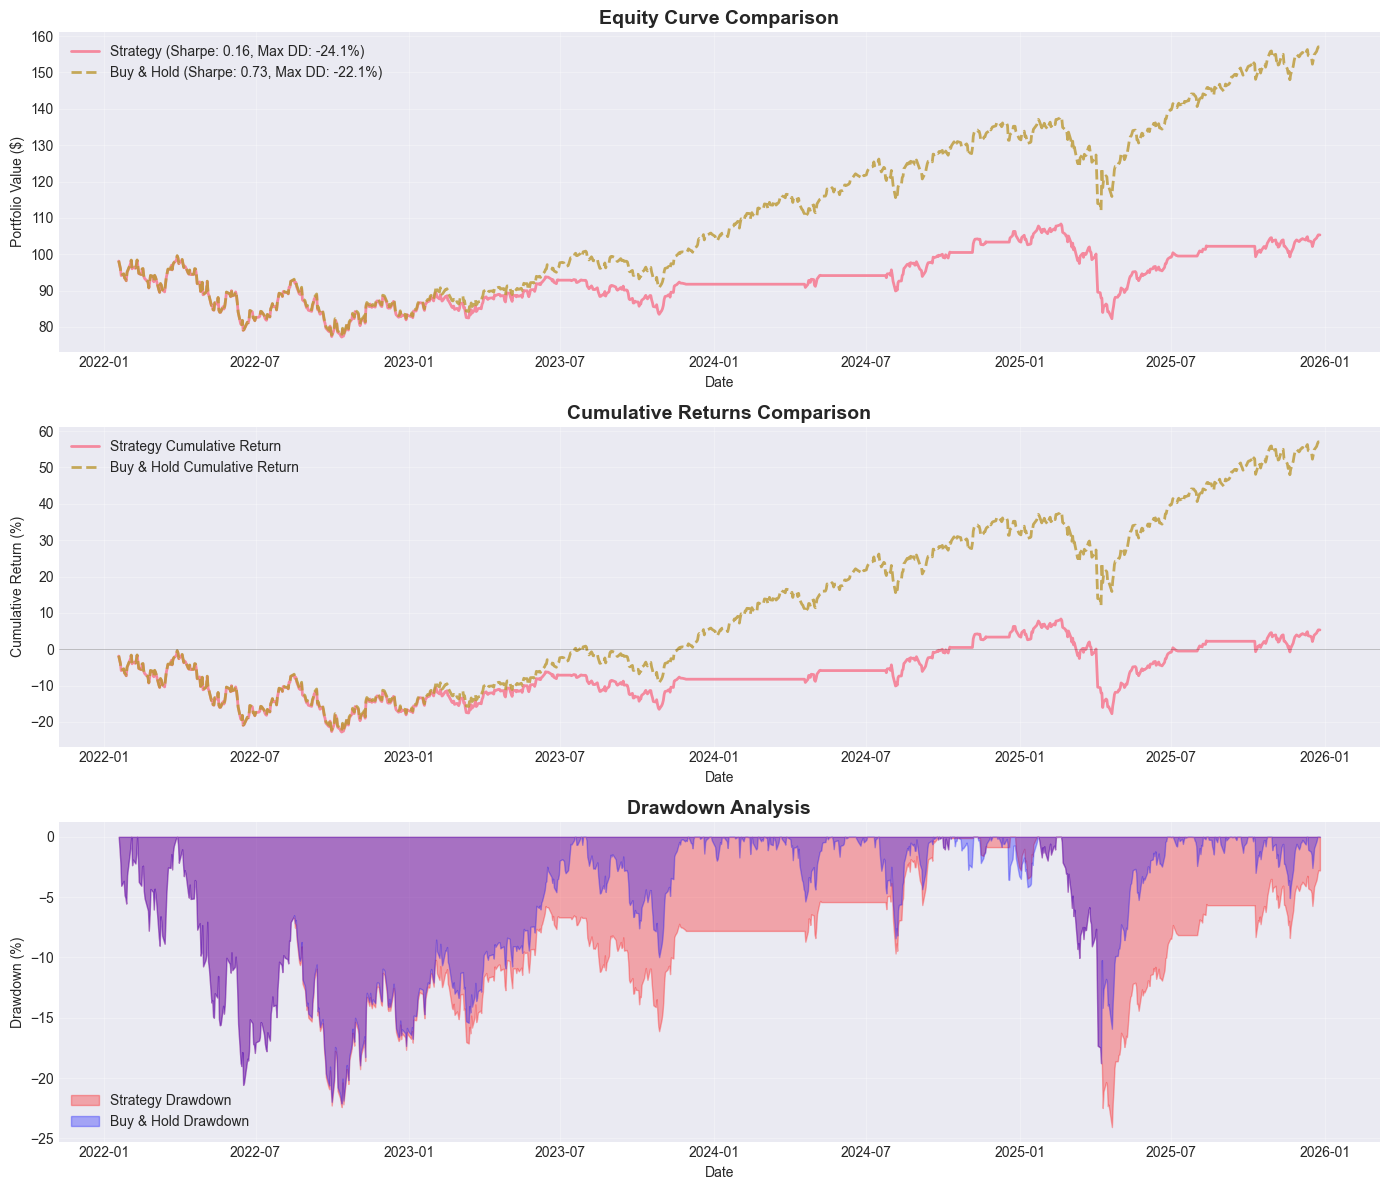


Final Summary
Strategy Total Return: 5.32%
Buy & Hold Total Return: 57.04%
Excess Return: -51.72%


In [7]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Equity Curve
axes[0].plot(results_df['time'], results_df['strategy_equity'], 
             label=f'Strategy (Sharpe: {strategy_sharpe:.2f}, Max DD: {strategy_max_dd*100:.1f}%)',
             linewidth=2, alpha=0.8)
axes[0].plot(results_df['time'], results_df['buy_hold_equity'], 
             label=f'Buy & Hold (Sharpe: {buy_hold_sharpe:.2f}, Max DD: {buy_hold_max_dd*100:.1f}%)',
             linewidth=2, alpha=0.8, linestyle='--')
axes[0].set_title('Equity Curve Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Portfolio Value ($)')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Cumulative Returns
strategy_cumret = (results_df['strategy_cumulative'] - 1) * 100
buyhold_cumret = (results_df['buy_hold_cumulative'] - 1) * 100

axes[1].plot(results_df['time'], strategy_cumret, 
             label='Strategy Cumulative Return', linewidth=2, alpha=0.8)
axes[1].plot(results_df['time'], buyhold_cumret, 
             label='Buy & Hold Cumulative Return', linewidth=2, alpha=0.8, linestyle='--')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Return (%)')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# Plot 3: Drawdown
running_max_strategy = results_df['strategy_equity'].expanding().max()
running_max_buyhold = results_df['buy_hold_equity'].expanding().max()
drawdown_strategy = (results_df['strategy_equity'] - running_max_strategy) / running_max_strategy * 100
drawdown_buyhold = (results_df['buy_hold_equity'] - running_max_buyhold) / running_max_buyhold * 100

axes[2].fill_between(results_df['time'], drawdown_strategy, 0, 
                      alpha=0.3, label='Strategy Drawdown', color='red')
axes[2].fill_between(results_df['time'], drawdown_buyhold, 0, 
                      alpha=0.3, label='Buy & Hold Drawdown', color='blue')
axes[2].set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Drawdown (%)')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "=" * 60)
print("Final Summary")
print("=" * 60)
print(f"Strategy Total Return: {(results_df['strategy_cumulative'].iloc[-1] - 1) * 100:.2f}%")
print(f"Buy & Hold Total Return: {(results_df['buy_hold_cumulative'].iloc[-1] - 1) * 100:.2f}%")
print(f"Excess Return: {((results_df['strategy_cumulative'].iloc[-1] - results_df['buy_hold_cumulative'].iloc[-1]) * 100):.2f}%")
print("=" * 60)
